In [1]:
from datasets.dtu import DTUDataset
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt
import cv2
import numpy as np
import time
import os

torch.backends.cudnn.benchmark = True # this increases inference speed a little

# Load pretrained model

In [2]:
from models.mvsnet import CascadeMVSNet
from utils import load_ckpt
from inplace_abn import ABN
model = CascadeMVSNet(n_depths=[8,32,48],
                      interval_ratios=[1.0,2.0,4.0],
                      num_groups=1,
                      norm_act=ABN).cuda()
load_ckpt(model, 'ckpts/_ckpt_epoch_10.ckpt')
model.eval()

CascadeMVSNet(
  (feature): FeatureNet(
    (conv0): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(8, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
    )
    (conv1): Sequential(
      (0): ConvBnReLU(
        (conv): Conv2d(8, 16, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (1): ConvBnReLU(
        (conv): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn): ABN(16, eps=1e-05, momentum=0.1, affine=True, activation=leaky_relu[0.01])
      )
      (2): ConvBnReLU(
        (conv): Conv2d(16, 16, k

In [18]:


# In[3]:


import subprocess
import os
from torch.utils.data import Dataset
import sys
ROOTDIR = "root/autodl-tmp"
sys.path.append(f'/{ROOTDIR}/project/dp_simple/')
from CasMVSNet_pl.datasets.utils import read_pfm
import os
import numpy as np
import cv2
from PIL import Image
import torch
from torchvision import transforms as T


import os
import json
import random
from pathlib import Path
from dataclasses import dataclass
from typing import Literal, Tuple, Optional
import numpy as np
from PIL import Image
from tqdm import tqdm
from cachetools import cached, LRUCache
from cachetools.keys import hashkey

import torch
from torch.utils.data import Dataset



class DTUDataset(Dataset):
    def __init__(self, config):
        """
        img_wh should be set to a tuple ex: (1152, 864) to enable test mode!
        """

        self.root_dir = config.root_dir
        self.split = config.split
        assert self.split in ['train', 'val', 'test'], \
            'split must be either "train", "val" or "test"!'
        
        self.dataset_id = config.dataset_id
        
        self.light_class = config.target_light
        self.img_wh = config.img_wh
        if config.img_wh is not None:
            if type(config.img_wh) is int:
                self.img_wh = (config.img_wh, config.img_wh)
            assert self.img_wh[0]%32==0 and self.img_wh[1]%32==0, \
                'img_wh must both be multiples of 32!'
        self.debug = config.debug
        self.read_bbox()
        self.threshold = config.threshold
        self.build_metas()
        self.n_views = config.n_views
        self.levels = config.levels # FPN levels
        self.depth_interval = config.depth_interval
        self.build_proj_mats()
        self.define_transforms()
        self.output_total = config.output_total
        prompt_dir = config.prompt_dir
        if prompt_dir != None:
            import json
            captions = json.load(open(prompt_dir))
        self.prompt_dir =captions
        
      
        
        
        
    def build_metas(self):
        self.metas = []
        import pickle
       
        
        
        split_path = os.path.join(self.root_dir, f'{self.split}.txt')
        bbox_path = os.path.join(self.root_dir, 'bbox.pkl')
        print("load split text of eth3d: ",split_path)
        print("load bbox of eth3d: ",bbox_path)
        self.metas = []
        import pickle as pkl
        with open(split_path) as f:
            self.scans = [line.rstrip() for line in f.readlines()]
        with open(bbox_path, 'rb') as f:
            self.total_pkl = pickle.load(f)
            
        for scan in self.scans:
            pair_file = "pair.txt"
            print(scan,self.root_dir, pair_file)
            pair_file = os.path.join(self.root_dir, scan, pair_file)
            with open(pair_file,"r") as f:
                num_viewpoint = int(f.readline())
                print(f"num_viewpoint: {num_viewpoint}")
                for _ in range(num_viewpoint):
                    ref_view = int(f.readline().rstrip())
                    src_views = [int(x) for x in f.readline().rstrip().split()[1::2]]
                    
                    self.metas += [(scan, ref_view,None, src_views,None)]
    


            

            
                         
    def build_proj_mats(self):
        proj_mats = []

        img_scan_whs = {}
       
        for scan in self.scans:
            target_filename = os.path.join(self.root_dir,
                                f'{scan}/images/{0:08d}.jpg')
            target_img = Image.open(target_filename)
            img_scan_whs[scan] = target_img.size[::-1]
        self.img_scan_whs = img_scan_whs    
            
       
        for meta in self.metas:
            scan, ref_view, _, src_views, _ = meta
            print("img_scan_whs; ",img_scan_whs)
            camera_file = os.path.join(self.root_dir, scan, f'cams_1/{ref_view:08d}_cam.txt')
            intrinsics, extrinsics, depth_min,depth_max = self.read_cam_file(camera_file)
            


            if self.img_wh is not None: # resize the intrinsics to the coarsest level
                width = img_scan_whs[scan][1]
                height = img_scan_whs[scan][0]
                print(width,height)
                intrinsics[0] *= 640/width/4
                intrinsics[1] *= 512/height/4

                # intrinsics[0] *= self.img_wh[0]/6223
                # intrinsics[1] *= self.img_wh[1]/4146

            K = intrinsics
            R = extrinsics
            proj_mat_ls = []
            for l in reversed(range(self.levels)):
                proj_mat_l = np.eye(4)
                proj_mat_l[:3, :4] = intrinsics @ extrinsics[:3, :4]
                intrinsics[:2] *= 2 # 1/4->1/2->1
                proj_mat_ls += [torch.FloatTensor(proj_mat_l)]
            # (self.levels, 4, 4) from fine to coarse
            proj_mat_ls = torch.stack(proj_mat_ls[::-1])
        
            proj_mats += [(proj_mat_ls, depth_min,K,R,depth_max)]

            self.proj_mats = proj_mats

    
    

    def read_cam_file(self, filename):
        with open(filename) as f:
            lines = [line.rstrip() for line in f.readlines()]
        # extrinsics: line [1,5), 4x4 matrix
        extrinsics = np.fromstring(' '.join(lines[1:5]), dtype=np.float32, sep=' ')
        extrinsics = extrinsics.reshape((4, 4))
        # intrinsics: line [7-10), 3x3 matrix
        intrinsics = np.fromstring(' '.join(lines[7:10]), dtype=np.float32, sep=' ')
        intrinsics = intrinsics.reshape((3, 3))
        # depth_min & depth_interval: line 11
        depth_min = float(lines[11].split()[0])
        depth_max = float(lines[11].split()[1])
        return intrinsics, extrinsics, depth_min,depth_max

    def read_depth(self, filename):
        depth = np.array(read_pfm(filename)[0], dtype=np.float32) # (1200, 1600)
        if self.img_wh is None:
            depth = cv2.resize(depth, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST) # (600, 800)
            depth_0 = depth[44:556, 80:720] # (512, 640)
        else:
            depth_0 = cv2.resize(depth, self.img_wh,
                                 interpolation=cv2.INTER_NEAREST)
        depth_1 = cv2.resize(depth_0, None, fx=0.5, fy=0.5,
                             interpolation=cv2.INTER_NEAREST)
        depth_2 = cv2.resize(depth_1, None, fx=0.5, fy=0.5,
                             interpolation=cv2.INTER_NEAREST)

        depths = {"level_0": torch.FloatTensor(depth_0),
                  "level_1": torch.FloatTensor(depth_1),
                  "level_2": torch.FloatTensor(depth_2)}
        
        return depths

    def read_mask(self, filename):
        mask = cv2.imread(filename, 0) # (1200, 1600)
       
        if self.img_wh is None:
            mask = cv2.resize(mask, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST) # (600, 800)
            mask_0 = mask[44:556, 80:720] # (512, 640)
        else:
            mask_0 = cv2.resize(mask, self.img_wh,
                                interpolation=cv2.INTER_NEAREST)
        mask_1 = cv2.resize(mask_0, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)   # 
        mask_2 = cv2.resize(mask_1, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)

        mask_3 = cv2.resize(mask_2, None, fx=0.5, fy=0.5,
                            interpolation=cv2.INTER_NEAREST)


        masks = {"level_0": torch.BoolTensor(mask_0),
                 "level_1": torch.BoolTensor(mask_1),
                 "level_2": torch.BoolTensor(mask_2),
                 "level_3": torch.BoolTensor(mask_3)}

        return masks
    def read_bbox(self):
        import pickle as pkl
        bbox_path = os.path.join(self.root_dir,"bbox.pkl")
        with open(bbox_path, 'rb') as f:
            bbox = pkl.load(f)
        self.bbox = bbox


    def define_transforms(self):
        if self.split == 'train': # you can add augmentation here
            self.transform = T.Compose([T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225]),
                                       ])
        else:
            self.transform = T.Compose([T.ToTensor(),
                                        T.Normalize(mean=[0.485, 0.456, 0.406], 
                                                    std=[0.229, 0.224, 0.225]),
                                       ])
        self.unpreprocess = T.Compose([
            T.Normalize(mean=[0, 0, 0], std=[1/0.229, 1/0.224, 1/0.225]),
            T.Normalize(mean=[-0.485, -0.456, -0.406], std=[1, 1, 1]),
        ])
    
    def decode_batch(self, batch):
        imgs = batch['imgs']
        proj_mats = batch['proj_mats']
        depths = batch['depths']
        masks = batch['masks']
        init_depth_min = batch['init_depth_min']
        depth_interval = batch['depth_interval']
        return imgs, proj_mats, depths, masks, init_depth_min, depth_interval

    def __len__(self):
        return len(self.metas)


    


    def  __getitem__(self, idx):
        
        scan, ref_view,light_idx, src_views,target_light = self.metas[idx]
        task = np.random.choice(["different dark"
                                # "different albedo",
                                #  "overexposed","shadow","different dark"
                                 ],1)
        
        view_ids = [ref_view] + src_views[:self.n_views-1]
        sample = {}
        imgs = []
        cams = []
        proj_mats = []
        target_imgs = []
        Ks = []
        Rs = []
        intensity_stats =[]
        index = np.random.randn(self.n_views)

        x_min = self.bbox[f"{scan}"]["x_min"]
        x_max = self.bbox[f"{scan}"]["x_max"]
        y_min = self.bbox[f"{scan}"]["y_min"]
        y_max = self.bbox[f"{scan}"]["y_max"]
        z_min = self.bbox[f"{scan}"]["z_min"]
        z_max = self.bbox[f"{scan}"]["z_max"]

        sample['prompt'] = [f"modify the images for task {task}"]
        index = index>0
        for i, vid in enumerate(view_ids):
        # NOTE that the id in image file names is from 1 to 49 (not 0~48)
            if True:
                img_filename = os.path.join(self.root_dir,
                                f'{scan}/images/{vid:08d}.jpg')
            else:
                if task == "different albedo":
                    img_filename = os.path.join(self.root_dir,
                                f'{scan}/images_albedo/different_albedo_{vid:08d}.jpg')
                elif task == "different dark":
                    img_filename = os.path.join(self.root_dir,
                                f'{scan}/images_dark/different_albedo_{vid:08d}.jpg')
                elif task == "overexposed":
                    img_filename = os.path.join(self.root_dir,
                                f'{scan}/images_shadow/different_shadow_{vid:08d}.jpg')
                else:
                    img_filename = os.path.join(self.root_dir,
                                f'{scan}/images_shadow/different_dark_{vid:08d}.jpg')


            target_filename = os.path.join(self.root_dir,
                                f'{scan}/images/{vid:08d}.jpg')
            # mask_filename = os.path.join(self.root_dir,
            #                 f'Depths/{scan}/depth_visual_{vid:04d}.png')
            # depth_filename = os.path.join(self.root_dir,
            #                 f'Depths/{scan}/depth_map_{vid:04d}.pfm')
    

            img = Image.open(img_filename)
            target_img = Image.open(target_filename)
            print(img.height,img.width)

            if self.img_wh is not None:
                print(self.img_wh)
                img = img.resize(self.img_wh, Image.BILINEAR)
                
                target_img = target_img.resize(self.img_wh, Image.BILINEAR)

            
                

            img = self.transform(img)
            print(img.shape)
            target_img = self.transform(target_img)
            imgs += [img]
            target_imgs += [target_img]

            proj_mat_ls, depth_min,K,R ,depth_max= self.proj_mats[vid]
            Ks += [K]
            Rs += [R]
        



            if i == 0:  # reference view
                sample["small_mask"]=[]
                
                sample['init_depth_min'] = torch.FloatTensor([depth_min])
                sample["init_depth_max"] = torch.FloatTensor([depth_max])
                
                
                ref_proj_inv = torch.inverse(proj_mat_ls)
            else:
                # small_mask = self.read_mask(mask_filename)["level_0"]
                # small_wh = (self.img_wh[0]/8,self.img_wh[1]/8)
                # sample["small_mask"] = interpolate(small_mask[None,None].float(), small_wh, mode='nearest')[0,0].byte()
                
                proj_mats += [proj_mat_ls @ ref_proj_inv]
            var, mean = torch.var_mean(img)
            intensity_stat = torch.stack([mean, var], dim=0)
            intensity_stats.append(intensity_stat)
    
    
        imgs = torch.stack(imgs) # (V, 3, H, W)
        
        target_imgs = torch.stack(target_imgs)
        proj_mats = torch.stack(proj_mats)[:,:,:3] # (V-1, self.levels, 3, 4) from fine to coarse
        
        # imgs = self.unpreprocess(imgs)
        # target_imgs = self.unpreprocess(target_imgs)
        
        
        



    
        Ks = np.stack(Ks)
        Rs = np.stack(Rs)
        sample['pose'] = torch.tensor(Rs)
        sample['K'] = torch.tensor(Ks)
        sample['images'] = imgs
        
        

        sample["intensity_stats"] = torch.stack(intensity_stats)
        sample['proj_mats'] = proj_mats
        sample['depth_interval'] = (torch.FloatTensor(sample["init_depth_max"])-torch.FloatTensor(sample["init_depth_min"]))/96   #torch.FloatTensor([1e-3])
        sample['scan_vid'] = (scan, view_ids)
        

        sample['target_imgs'] = target_imgs

        sample["bbox"] =torch.tensor([[x_min,y_min,z_min], 
                                    [x_max,y_max,z_max]], dtype=torch.float32)




        return sample




        





# %%
@dataclass
class DTUConfig:
    """Arguments for setup of the CO3Dv2_Dataset."""

   
    

    category: Optional[str] = None
    """If specified, only selects this category from the dataset. Can be a comma-separated list of categories as well."""

    subset: Optional[str] = None
    """If specified, only selects images corresponding to this subset. See https://github.com/facebookresearch/co3d for available options."""

    split: Optional[str] = None
    """Must be specified if --subset is specified. Tells which split to use from the subset."""

    max_sequences: int = -1
    """If >-1, randomly select max_sequence sequences per category. Only sequences _with pointclouds_ are selected. Mutually exclusive with --sequence."""

    seed: Optional[int] = 42
    """Random seed for all rng objects"""
 
    split: Optional[str] = "val"
    """Must be specified if --subset is specified. Tells which split to use from the subset."""

    root_dir: str =f"/root/autodl-tmp/eth3d_high_res_test"
    target_light = 6
    n_views:int=3 
    levels:int=3 
    depth_interval:int =2.65
    img_wh:int=(640,512)
    abs_error:Optional[str] ="abs"
    output_total:Optional[bool]=False
    threshold: Optional[int] = 0.8
    prompt_dir: Optional[str] = f"/{ROOTDIR}/mvs_training/dtu/co3d_blip2_captions_final.json"
    debug: Optional[int] = 0
    light_strength: int =  200
    light_gamma: int =  1.2
    dataset_id: str = "eth3d"
    


# %%
val_data = DTUDataset(DTUConfig)


load split text of eth3d:  /root/autodl-tmp/eth3d_high_res_test/val.txt
load bbox of eth3d:  /root/autodl-tmp/eth3d_high_res_test/bbox.pkl
living_room /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 65
lounge /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 10
meadow /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 15
observatory /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 27
office /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 26
old_computer /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 54
pipes /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 14
playground /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 38
relief /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 31
relief_2 /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 31
statue /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 11
terrace /root/autodl-tmp/eth3d_high_res_test pair.txt
num_v

In [19]:
dataset = DTUDataset(DTUConfig)

load split text of eth3d:  /root/autodl-tmp/eth3d_high_res_test/val.txt
load bbox of eth3d:  /root/autodl-tmp/eth3d_high_res_test/bbox.pkl
living_room /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 65
lounge /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 10
meadow /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 15
observatory /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 27
office /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 26
old_computer /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 54
pipes /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 14
playground /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 38
relief /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 31
relief_2 /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 31
statue /root/autodl-tmp/eth3d_high_res_test pair.txt
num_viewpoint: 11
terrace /root/autodl-tmp/eth3d_high_res_test pair.txt
num_v

In [20]:
def decode_batch(batch):
    imgs = batch['target_imgs']
    proj_mats = batch['proj_mats']
    #depths = batch['depths']
    #masks = batch['masks']
    init_depth_min = batch['init_depth_min'].item()
    depth_interval = batch['depth_interval'].item()
    return imgs, proj_mats, None, None, init_depth_min, depth_interval

imgs, proj_mats, depths, masks, init_depth_min, depth_interval = decode_batch(dataset[110])
unpreprocess = T.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225], 
                           std=[1/0.229, 1/0.224, 1/0.225])

4130 6198
(640, 512)
torch.Size([3, 512, 640])
4130 6198
(640, 512)
torch.Size([3, 512, 640])
4130 6198
(640, 512)


torch.Size([3, 512, 640])


inference time 0.09223604202270508


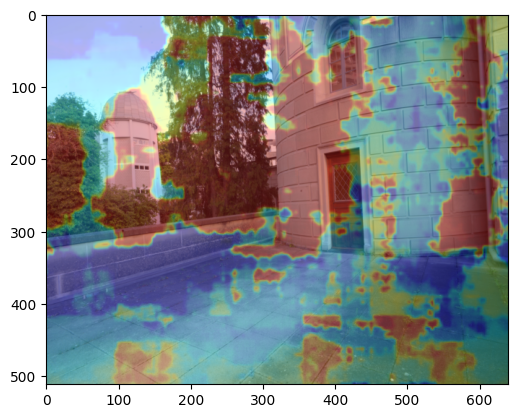

In [21]:
t = time.time()
with torch.no_grad():
    
    results = model(imgs.unsqueeze(0).cuda(), proj_mats.unsqueeze(0).cuda(), init_depth_min, depth_interval)
    torch.cuda.synchronize()
print('inference time', time.time()-t)
from utils import *
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.3)

In [22]:
# from utils import *
# normalize_depth(depths['level_0']).shape

# Visualize an example depth

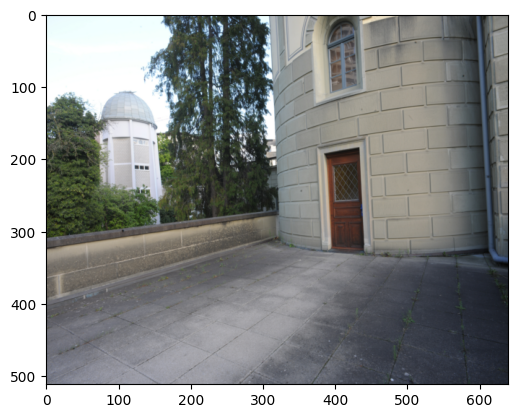

In [23]:


plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
# plt.imshow(visualize_depth(depths['level_0']).permute(1,2,0), alpha=0.5)

In [24]:
imgs.shape,proj_mats.shape

(torch.Size([3, 3, 512, 640]), torch.Size([2, 3, 3, 4]))

# Do inference on this sample

inference time 0.06871771812438965


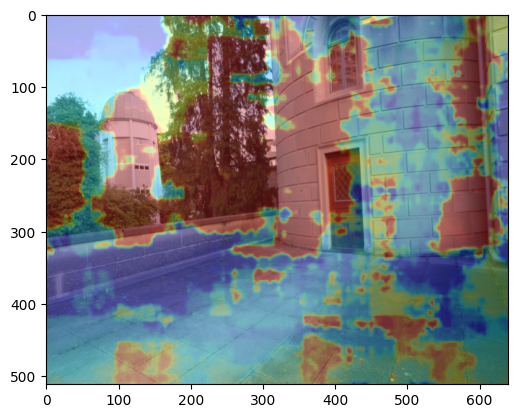

In [25]:
t = time.time()
with torch.no_grad():
    
    results = model(imgs.unsqueeze(0).cuda(), proj_mats.unsqueeze(0).cuda(), init_depth_min, depth_interval)
    torch.cuda.synchronize()
print('inference time', time.time()-t)
from utils import *
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.3)

In [26]:
results['depth_0'][0]

tensor([[8.7388, 8.6737, 8.6051,  ..., 4.6773, 4.7241, 4.7764],
        [8.6874, 8.6289, 8.5842,  ..., 4.6359, 4.6843, 4.7346],
        [8.6383, 8.5964, 8.5692,  ..., 4.6052, 4.6522, 4.6980],
        ...,
        [5.8022, 5.7635, 5.7301,  ..., 5.1670, 5.1632, 5.1597],
        [5.8079, 5.7654, 5.7251,  ..., 5.1292, 5.1318, 5.1363],
        [5.8194, 5.7703, 5.7222,  ..., 5.0954, 5.1026, 5.1138]],
       device='cuda:0')

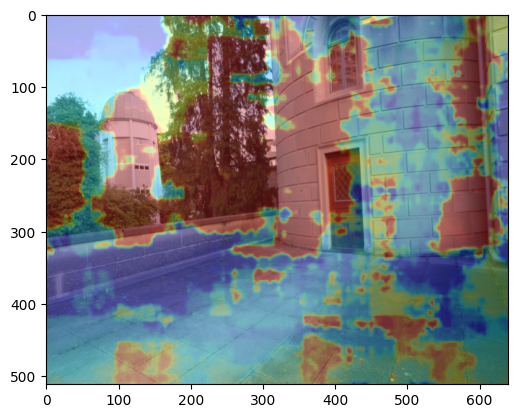

In [27]:
#plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
from utils import *
plt.imshow(unpreprocess(imgs[0]).permute(1,2,0))
plt.imshow(visualize_depth(results['depth_0'][0]).permute(1,2,0), alpha=0.3)

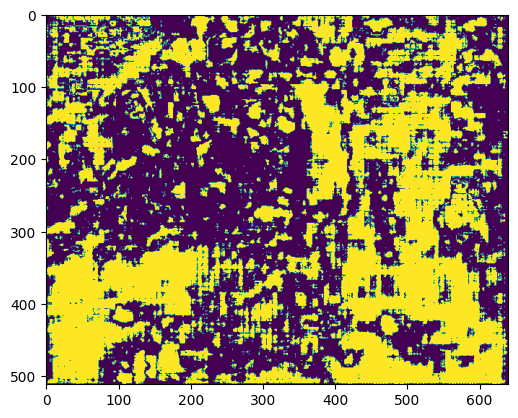

In [28]:
plt.imshow(results['confidence_0'][0].cpu().numpy()>0.999)

# Reference: show pixels whose absolute depth error is less than 2mm

In [29]:
err2 = torch.abs(depths['level_0']-results['depth_0'].cpu())[0]<2
plt.imshow(err2);
print('acc_2mm :', ((err2.float()*masks['level_0']).sum()/masks['level_0'].sum()).item())

TypeError: 'NoneType' object is not subscriptable